# TolTEC observation simulator: Step by Step

Authors: Zhiyuan Ma

## Prerequisites

* Tutorial: tolteca_setup

## Objectives

* Use the commandline interface to run `tolteca.simu`.
* Use the Python API to run `tolteca.simu`.
* Learn about advanced usage of the TolTEC observation simulator:
    * Scripting and parallelization with commandline inteface.
    * Generate mapping patterns and compute approximate coverage map.
    * Pre-render point source catalogs as FITS images.
    * Use TolTEC power loading model to predict the map depth.
    * Explore the internals of the simulator workflow:
        * Array property table and KIDs resonance models
        * Converting between on-sky signal to raw KIDs stream
    * Examine the KIDs data in raw timestream netCDF file


## Keywords

Commandline interface; Simulation;

## Summary

In this tutorial, we will learn to use the `tolteca.simu` module for making simulated TolTEC
observation.

The `tolteca.simu` can be invoked either with the ``tolteca simu`` command line interface, or throught
the use of `tolteca.simu.SimulatorRuntime` in Python. In both case, a `RuntimeContext` is required to
manage the configuration of the module, handled by the class `tolteca.simu.SimuConfig`.

## Run the simulator

The simulator requires a config dict to run. The config can be provided using the ``tolteca workdir`` and `RuntimeContext` machinery. To learn about setting up workdir and load `RuntimeContext`, refer to `tutorial: tolteca_setup`.

### Commandline interface (recommended)

```
$ tolteca -d workdir0 setup
```

This will create a directory named `workdir0` in the current directory, with some initial contents similar to:

```
$ cd workdir0 && ls
40_setup.yaml README.md bin/ cal/ doc/ log/
```

Once the workdir is setup, create a file named `60_simu.yaml` with the content below and put it in the workdir:

```
# example 60_simu.yaml for tutorial: tolteca_simu
simu:
  jobkey: simu_three_sources
  instrument:
    name: toltec
    polarized: false
  mapping:
    type: raster
    length: 10 arcmin
    space: 1 arcmin
    n_scans: 11
    speed: 5 arcmin/s
    rot: 0 deg
    t_turnaround: 1s
    target: 180d 0d
    t0: 2022-05-01T06:00:00
    ref_frame: altaz
  obs_params:
    t_exp: null
  sources:
  - type: point_source_catalog
    filepath: three_sources.txt
    data_cols:
    - colname: f_{{array_name}}
      array_name: ["a1100", "a1400", "a2000"]
  - type: toltec_power_loading
    atm_model_name: am_q50
```

Then we created the ``three_sources.txt`` point source catalog file and put it in the same directory:

```
# name ra     dec    f_a1100 f_a1400 f_a2000
  src0 180.   0.     10       20       30
  src1 180.01 0.     20       30       40
  src2 180.01 -0.01  30       40       50
```

Now we are ready to run the simulator, which can be done by:

```
$ tolteca simu
```

The simulated data files will be write to the directory `simu_three_sources` (specified as jobkey):

```
$ cd simu_three_sources && ls
apt_000001_000_0000_2022_03_23_15_56_56.ecsv
hwp_000001_000_0000_2022_03_23_15_56_56.nc
simustate.yaml
simustate_000001_000_0000_2022_03_23_15_56_56.yaml
tel_000001_000_0000_2022_03_23_15_56_56.nc
toltec0_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec10_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec11_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec12_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec1_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec2_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec3_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec4_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec5_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec6_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec7_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec8_000001_000_0000_2022_03_23_15_56_56_timestream.nc
toltec9_000001_000_0000_2022_03_23_15_56_56_timestream.nc
tolteca_000001_000_0000_2022_03_23_15_56_56.yaml
```

The output files ``{tel,hwp,toltec}*.nc`` are of the same shape as the real data, and other files are specific to the simulator.


### Python API

The main content of this tutorial will be to demonstrate the Python API of the `tolteca.simu` module. The entry point class for running the simulator is `SimulatorRuntime`, which is one of the subclasses of the `tolteca.utils.runtime_context.RuntimeBase`. `RuntimeBase` acts as a proxy of an underlying `RuntimeContext` object, providing a unified interface for subclasses to managed specialized config objects constructed from the config dict of the runtime context and its the runtime info.

The `SimulatorRuntime` can be constructed the same way as the `RuntimeContext`, except that it requires the config backends being already setup. Here we'll create the config dict in Python and pass it to create (implicitly) an in-memory `RuntimeContext`:

In [1]:
# import some common packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget

import astropy.units as u
from tolteca.simu import SimulatorRuntime
from tolteca.utils.runtime_context import yaml_load
from tollan.utils.fmt import pformat_yaml
from tollan.utils.log import init_log
init_log(level='INFO')

import tempfile
from pathlib import Path
from contextlib import ExitStack

# the config needs the point source catalog file which we'll create in a temporary directory:
es = ExitStack()  # to manage the tempdir
tmpdir = Path(es.enter_context(tempfile.TemporaryDirectory()))
print(f"Temporary directory: {tmpdir}")

with open(tmpdir.joinpath('three_sources.txt'), 'w') as fo:
    fo.write(r'''# name ra     dec    f_a1100 f_a1400 f_a2000
  src0 180.   0.     10       20       30
  src1 180.01 0.     20       30       40
  src2 180.01 -0.01  30       40       50    
    ''')

# now create the config dict.
config_dict = yaml_load("""
simu:
  jobkey: simu_three_sources
  instrument:
    name: toltec
    polarized: false
  mapping:
    type: raster
    length: 10 arcmin
    space: 1 arcmin
    n_scans: 11
    speed: 5 arcmin/s
    rot: 0 deg
    t_turnaround: 1s
    target: 180d 0d
    t0: 2022-05-01T06:00:00
    ref_frame: altaz
  obs_params:
    t_exp: null
  sources:
  - type: point_source_catalog
    filepath: three_sources.txt
    data_cols:
    - colname: f_{{array_name}}
      array_name: ["a1100", "a1400", "a2000"]
  - type: toltec_power_loading
    atm_model_name: am_q50
    atm_cache_dir: null
""")
# add the tmpdir as the rootpath of the runtime context and set some
# required directories
config_dict.update({
    'runtime_info': {
        'logdir': tmpdir,
        'config_info': {
            'runtime_context_dir': tmpdir
            }
        }
    })

# now create the simualtor runtime
simrt = SimulatorRuntime(config_dict)
print(f'Created simulator runtime {simrt}')
# print(f'Runtime info dict: {pformat_yaml(simrt.rc.runtime_info.to_dict())}')
print(f'Simu config dict: {pformat_yaml(simrt.config.to_config_dict())}')

Temporary directory: /var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b
Created simulator runtime <tolteca.simu.SimulatorRuntime object at 0x1361074c0>


[INFO] ToltecObsSimulatorConfig: use array prop table from calobj <tolteca.cal.ToltecCalib object at 0x136113f70>
[WARNING] astroquery: InputWarning: Coordinate string is being interpreted as an ICRS coordinate.


Simu config dict: 
simu:
  export_only: false
  exports: []
  instrument:
    array_prop_table:
    calobj_index: cal/default/index.yaml
    hwp:
      f_rot: 4.0 Hz
      f_smp: 20.0 Hz
      rotator_enabled: false
    name: toltec
    polarized: false
  jobkey: simu_three_sources
  mapping:
    length: 10.0 arcmin
    n_scans: '11.0'
    ref_frame: altaz
    rot: 0.0 deg
    space: 1.0 arcmin
    speed: 5.0 arcmin / s
    t0: '2022-05-01 06:00:00'
    t_turnaround: 1.0 s
    target: 180d 0d
    target_frame: icrs
    type: raster
  obs_params:
    f_smp_mapping: 12.0 Hz
    f_smp_probing: 120.0 Hz
    t_exp:
  output_context: {}
  perf_params:
    anim_frame_rate: 300.0 s
    aplm_eval_interp_alt_step: 2.0 arcmin
    catalog_model_render_pixel_size: 0.5 arcsec
    chunk_len: 10.0 s
    mapping_erfa_interp_len: 300.0 s
    mapping_eval_interp_len:
    pre_eval_sky_bbox_padding_size: 4.0 arcmin
    pre_eval_t_grid_size: 200
  plot_only: false
  plots: []
  sources:
    - data_cols:
   

To run the simulator, simply call the `SimulatorRuntime.run` method:

In [2]:
output_dir = simrt.run()

[INFO] SimuConfig: use t_simu=32.0 s from mapping pattern
[INFO] SimulatorRuntime: setup logging to file /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu.log
[WARNING] ToltecSimuOutputContext: overwrite invalid state entry:

filepath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/simustate.yaml
state:
  cal_obsnum: 1
  cal_scannum: 0
  cal_subobsnum: 0
  obsnum: 1
  scannum: 0
  subobsnum: 0

[INFO] ToltecSimuOutputContext: simulator output state:

filepath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/simustate.yaml
state:
  cal_obsnum: 1
  cal_scannum: 0
  cal_subobsnum: 0
  obsnum: 1
  scannum: 0
  subobsnum: 0
  ut: 2022-03-26 03:23:19.062757
  valid: false

[INFO] SimulatorRuntime: write output to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources
[INFO] make_time_grid: make time chunks with n_times_per_chunk=1200 n_times=3840 n_chunks=

[WARNING] astroquery: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.
[INFO] ToltecObsSimulator: det sky traj bbox:
ra: 179d54m16.05410195s - 180d05m43.90779816s
dec: -0d07m34.37031698s - 0d06m46.73597658s
az: 241d44m21.1166766s - 242d10m47.60552144s
alt: 53d30m58.3552125s - 53d36m37.32785093s
size: 0.1910704711687572 deg, 0.23919619265795056 deg
[INFO] ToltecObsSimulator: source surface brightness at detector: min=0.0 MJy / sr max=43.82540180796531 MJy / sr
[INFO] ToltecObsSimulator: summary of simulated chunk for a1100:
var     min           max          med            mean             std       
--- ----------- --------------- ---------- ----------------- ----------------
  S  0 MJy / sr 43.825 MJy / sr 0 MJy / sr 0.012083 MJy / sr 0.45927 MJy / sr
  P   14.668 pW       14.683 pW  14.675 pW         14.675 pW     0.0019277 pW
  x -4.2187e-07      4.6135e-07 1.4232e-08        1.4267e-08       1.1169e-07
  r       5e-05

[INFO] ToltecObsSimulator: summary of simulated chunk for a2000:
var     min           max           med            mean              std       
--- ----------- --------------- ----------- ------------------ ----------------
  S  0 MJy / sr 22.339 MJy / sr  0 MJy / sr 0.0043926 MJy / sr 0.20827 MJy / sr
  P   7.0829 pW       7.0913 pW   7.0862 pW          7.0862 pW    0.00070457 pW
  x -4.1464e-07      5.0967e-07 -5.2058e-08        -5.1979e-08       7.7503e-08
  r       5e-05           5e-05       5e-05              5e-05       1.3553e-19
  I  1.9998e+06           2e+06       2e+06              2e+06           9.2057
  Q      -21264           28171      3616.9               3766           4669.5

[INFO] ToltecSimuOutputContext: write [2400:3600] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/tel_000001_000_0000_2022_03_26_03_23_19.nc
[INFO] ToltecSimuOutputContext: write [684][2400:3600] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000

[INFO] ToltecSimuOutputContext: write [618][3600:3840] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec6_000001_000_0000_2022_03_26_03_23_19_timestream.nc
[INFO] ToltecSimuOutputContext: write [676][3600:3840] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec7_000001_000_0000_2022_03_26_03_23_19_timestream.nc
[INFO] ToltecSimuOutputContext: write [588][3600:3840] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec8_000001_000_0000_2022_03_26_03_23_19_timestream.nc
[INFO] ToltecSimuOutputContext: write [590][3600:3840] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec9_000001_000_0000_2022_03_26_03_23_19_timestream.nc
[INFO] ToltecSimuOutputContext: write [680][3600:3840] to /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec10_000001_000_0000_2022_03_26_03

The output directory is returned if the run is successful and we can list the content:

In [3]:
print(f"Content of the output dir: {output_dir}\n:{pformat_yaml([p.name for p in output_dir.iterdir()])}")

Content of the output dir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources
:
- toltec11_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec4_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec5_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- simustate.yaml
- toltec10_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec7_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec12_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- tolteca_000001_000_0000_2022_03_26_03_23_19.yaml
- toltec6_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec9_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- apt_000001_000_0000_2022_03_26_03_23_19.ecsv
- toltec8_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- tel_000001_000_0000_2022_03_26_03_23_19.nc
- toltec1_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec0_000001_000_0000_2022_03_26_03_23_19_timestream.nc
- toltec2_000001_000_0000_2022_03_26_03_23_19_timestream.nc


The output files can then be used as input of the `tolteca.reduce` module, which invokes the data reduction engine (``Citlali`` by default) to create maps. For further information, refer to `Tutorial: tolteca_reduce`.

## (Optional) Advanced Usages and Internals of the Simulator

The rest of this tutorial covers the advance usages of the simulator and the internals of the simulator implementation.

### Scripting and parallization

In the previous section, the simulation we ran produces a single "observation". For real scientific projects, it is often desired to run multiple observations of a target to reach the desired depth, or coverage. Also, to mimic the behavior of the actual data acquisition system used on LMT, the simulator uses a ``simustate.yaml`` file to keep track of the ``obsnum`` and imposes a write lock to avoid simuteneous writes to the same output directory. Therefore, care must be taken when one tries to run multiple simulations at the same time.

Both the commandline interface and the Python API allow for such customized usage pattern.

#### Overriding the config on-the-fly with commandline arguments

When run simulator in commandline, the YAML config can be overriden by using the following syntax:

```
$ tolteca simu --jobkey three_sources_toast_atm --sources.1.atm_model_name toast --perf_params.pre_eval_sky_bbox_padding_size "10 arcmin"
```

The above will alter the config dict defined in ``60_simu.yaml`` file so that the jobkey (i.e., the output directory) is ``three_sources_toast_atm``, the TolTEC power loading model set to use ``toast`` as the atmosphere model, and the pre-evaluation padding set to 10 arcmin to avoid possible missing data in the generated atmosphere slabs for TOAST.

The ability to override config on the commandline interface can be also used to simulating back-to-back observations, for example, if we would like to run the same raster pattern three times, each have a time-of-completion of 20 min, we could do the following in a bash script:

```
#!/bin/bash
tolteca simu --mapping.t0 "2022-01-01 12:00:00" --jobkey "back_to_back_run"
tolteca simu --mapping.t0 "2022-01-01 12:20:00" --jobkey "back_to_back_run"
tolteca simu --mapping.t0 "2022-01-01 12:40:00"  --jobkey "back_to_back_run"
```

The generated data files will have consecutive obsnums, the same as what one would get from executing the same three observations with LMT.

The limitation of the above script is that, due to the output directory write lock, the simulations have to be run sequentially, which takes a long time if the simulation is large.

To overcome the limitation and run multiple related simulations like above, one has to specify different jobkeys so each of the job will have its own writelock (in the respective output directories) and they don't conflict. In this case, however, because each output directory has its own simustate.yaml file, the obsnum will be conflicting by default. To mitigate the issue, one could pass a user-defined state to specify the initial obsnum via the ``output_context`` config dict:

```
#!/bin/bash
tolteca simu --mapping.t0 "2022-01-01 12:00:00" --jobkey "back_to_back_run0" --output_context.state_init.obsnum 1 &
tolteca simu --mapping.t0 "2022-01-01 12:20:00" --jobkey "back_to_back_run1" --output_context.state_init.obsnum 101 &
tolteca simu --mapping.t0 "2022-01-01 12:40:00"  --jobkey "back_to_back_run2" --output_context.state_init.obsnum 201 &
wait
```

This will invoke the three commands as background jobs in parallel. Each of the job has its own jobkey and the obsnums are set to start from 1, 101, and 201, respectively. If the output directories are freshly created, the generated observations will have obsnums 1, 101, and 201, which can be safely merged into one directory and used as inputs for creating co-added maps. Subsequent run of the script will create observations of obsnums 2, 102, and 202, and so on and so forth.

#### Overriding the config with Python API

The method `SimulatorRuntime.update` could be used to override the config when running the simulator with Python:

In [4]:
# make a copy of the simrt object before the update
# this is done by constructing a new runtime object
# with the underlying runtime context
simrt1 = SimulatorRuntime(simrt.rc)
simrt1.update({'simu': {"jobkey": "my_jobkey"}})
print(f"Updated jobkey: {simrt1.config.jobkey}")

[INFO] ToltecObsSimulatorConfig: use array prop table from calobj <tolteca.cal.ToltecCalib object at 0x10b98fbb0>
[WARNING] astroquery: InputWarning: Coordinate string is being interpreted as an ICRS coordinate.


Updated jobkey: my_jobkey


Please note that the dict taken by the `SimulatorRuntime.update` method has to be under the namespace ``simu``, while in the commandline, the arguments does not have the ``simu.`` prefix.

The same caveat on running simulations in parallel also applies to the Python API.

### Generate mapping trajectories and compute approximate coverage map

The submodule ``tolteca.simu.mapping`` defines a set of models that could generate mapping pattern that are used by the LMT for on-the-fly (OTF) mapping. The module provides the machinery that one could use for planning observations with TolTEC.

In the below, we'll genrate a lissajous pattern for observing the galaxy M51, and an approximate coverage map from the mapping pattern and the TolTEC focal plane layout.

We begin by picking the best observation time for the target, which is done making use of the ``astroplan`` package back the scene.

[INFO] plot_visibility: Visibility of targets on day of 2022-05-01 00:00:00.000
target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
        M51            True             False          0.3958333333333333


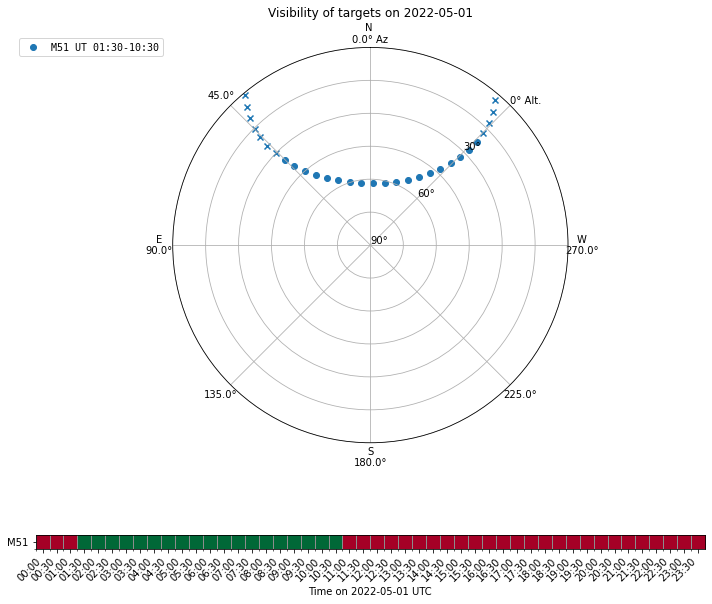

(<Figure size 864x720 with 2 Axes>, GridSpec(2, 1, height_ratios=[4, 1]))

In [5]:
from tolteca.simu.plots import plot_visibility
from astroquery.utils import parse_coordinates
from astropy.time import Time

m51_coords = parse_coordinates("M51")

plot_visibility(t0=Time("2022-05-01"), targets=[m51_coords, ], target_names=['M51'], show=True)

The visiblity plot indicates that we could observe the target between 1:30 and 10:30 UT.

Then we create the mapping pattern model with is a 5' by 5' lissajous pattern. Note that the ``x_omega`` and ``y_omega`` are the angular frequencies of the underlying sinunoidial functions in x and y direction and the scan speed in each direction is estimated to be ``0.5 * length * omega``.

mapping pattern model:
Model: SkyLissajousModel
Name: lissajous
Inputs: ('t',)
Outputs: ('lon', 'lat')
Model set size: 1
Parameters:
    x_length y_length  x_omega   y_omega  delta rot
     arcmin   arcmin  cycle / s cycle / s  deg  deg
    -------- -------- --------- --------- ----- ---
         5.0      5.0       0.5     0.511  45.0 0.0
t_pattern=194.0 s


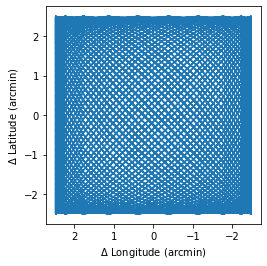

In [6]:
from tolteca.simu.mapping.lissajous import SkyLissajousModel
m_lissajous = SkyLissajousModel(
    x_length=5 << u.arcmin, y_length=5 << u.arcmin,
    x_omega=0.5 << u.cy / u.s, y_omega=0.511 << u.cy / u.s,
    delta=45 << u.deg,
    rot=0 << u.deg,
    )
# the time to finish the pattern
t_pattern = m_lissajous.t_pattern
print(f"mapping pattern model:\n{m_lissajous}\nt_pattern={t_pattern}")
# make a time grid for evaluating the pattern
t_grid = np.arange(0, t_pattern.to_value(u.s), 0.1) << u.s
dlon, dlat = m_lissajous(t_grid)
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.plot(dlon, dlat)
ax.set_xlabel('$\Delta$ Longitude (arcmin)')
ax.set_ylabel('$\Delta$ Latitude (arcmin)')
ax.invert_xaxis()

The mapping pattern model produces the mapping pattern in relative coordinates. The pattern is not related to any specific sky coordinates frame yet.

To attach the mapping pattern to the target coordinate, in our case, the M51, we'll make use of the `astropy.coordinates.SkyOffsetFrame` from astropy. Note that here we need to make the choose of the ``ref_frame``, which is the coordinates frame in which the mapping pattern is applied. For LMT/TolTEC, the native choice is to use the ``AltAz`` frame, which requires the observation time as input. Here according to our visibility plot, we choose the observation time to be at 2022-05-01 6:00:00 UT.

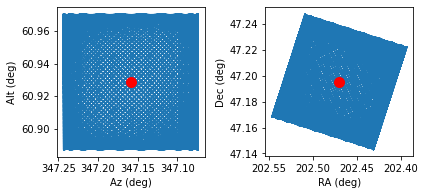

In [7]:
# we obtain altaz frame for the observation,
# using the astroplan observer instance from the lmt_info dict
from tolteca.simu.lmt import lmt_info
from astropy.coordinates import SkyCoord

lmt_observer = lmt_info['observer']
t0 = Time("2022-05-01T06:00:00")
m51_icrs = m51_coords.transform_to("icrs")  # no-op
m51_altaz = m51_coords.transform_to(lmt_observer.altaz(time=t0))
m51_altaz_offset_frame = m51_altaz.skyoffset_frame()
m51_mapping_traj_altaz = SkyCoord(dlon, dlat, frame=m51_altaz_offset_frame).transform_to(m51_altaz)
# transform the trajectory to ICRS
m51_mapping_traj_icrs = m51_mapping_traj_altaz.transform_to('icrs')

# make the trajectory plot
fig, axes = plt.subplots(1, 2)
fig.set_tight_layout(True)
# altaz
ax = axes[0]
ax.set_aspect(1 / np.cos(m51_mapping_traj_altaz.alt.mean()))
ax.plot(m51_mapping_traj_altaz.az.degree, m51_mapping_traj_altaz.alt.degree)
ax.plot(m51_altaz.az.degree, m51_altaz.alt.degree, label='M51', marker='o', markersize=10, color='red')
ax.set_xlabel('Az (deg)')
ax.set_ylabel('Alt (deg)')
ax.invert_xaxis()
# icrs
ax = axes[1]
ax.set_aspect(1 / np.cos(m51_mapping_traj_icrs.dec.mean()))
ax.plot(m51_mapping_traj_icrs.ra.degree, m51_mapping_traj_icrs.dec.degree)
ax.plot(m51_icrs.ra.degree, m51_icrs.dec.degree, label='M51', marker='o', markersize=10, color='red')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.invert_xaxis()

Using the mapping trajectories created above, we could generate approximated coverage map if we also know the focal plane layout, for instruments like TolTEC, by convolving the focal plane layout image with mapping pattern.

The coverage map obtained this way is approximate, because it assumes a constant focal plane layout throughout the observation, which is not the case due to the rotation of the FOV when the telescope is pointed at different altitudes. For TolTEC, because the focal plane layout is largely central symmetric, the difference is not large.

To create the coverage map, we use the function `tolteca.simu.utils.make_cov_hdu_approx`:

> TODO: refactor ``tolteca.web.templates.obs_planner`` to move ``_make_cov_hdu_approx`` to tolteca.simu.utils.
  Then update the snippet here for creating the coverage map.

In [8]:
# TODO demostrate the coverage map creation here
# from tolteca.simu.uitls import make_cov_hdu_approx
# hdu_cov = make_cov_hdu_approx(...)

### Pre-render point source catalogs as FITS images

In the simulation config, we added two simulation sources, one is a point source catalog, the other is the power loading model for TolTEC. Internally, the astronomical signal probed by the simulator is a FITS image model (`tolteca.simu.sources.models.ImageSourceModel`) instance that is created with the point source catalog at the begining of the simulation run.

When the point source catalog contains a lot of sources, this conversion may take a long time. It is then a waste of time if one would like to run the simulator multiple times with different mapping patterns.

In this case, it is helpful to pre-render the point source catalog as FITS images and specify the renderred FITS image in the sources list in the simulator config. Here we walk through the steps: 

name   ra    dec  f_a1100 f_a1400 f_a2000
---- ------ ----- ------- ------- -------
src0  180.0   0.0      10      20      30
src1 180.01   0.0      20      30      40
src2 180.01 -0.01      30      40      50
Model: CatalogSourceModel
Inputs: ('label', 'lon', 'lat', 'pa')
Outputs: ('S',)
Model set size: 1
Parameters:
                           hdu                            
----------------------------------------------------------

Array_name: a1100
Beam_area: 28.327 arcsec2
Beam_area_pix2: 708.181 pix2
'MJy/sr per mJy/beam': 1.50
'mJy/beam per MJy/sr': 0.67


Array_name: a1400
Beam_area: 45.885 arcsec2
Beam_area_pix2: 1147.137 pix2
'MJy/sr per mJy/beam': 0.93
'mJy/beam per MJy/sr': 1.08


Array_name: a2000
Beam_area: 93.644 arcsec2
Beam_area_pix2: 2341.095 pix2
'MJy/sr per mJy/beam': 0.45
'mJy/beam per MJy/sr': 2.20



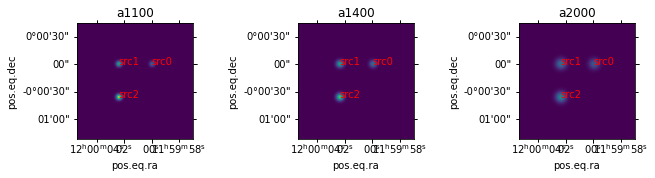

In [9]:
# First we load the catalog
from astropy.table import Table
cat = Table.read(tmpdir.joinpath('three_sources.txt'), format='ascii.commented_header')
print(cat)

# create the catalog source model
# here we associate the flux columns with the TolTEC
# array names using the data_cols list
from tolteca.simu.sources.models import CatalogSourceModel

m_cat = CatalogSourceModel(
        catalog=cat,
        data_cols=[
            {
                'colname': 'f_a1100',
                'array_name': 'a1100'
                },
            {
                'colname': 'f_a1400',
                'array_name': 'a1400'
                },
            {
                'colname': 'f_a2000',
                'array_name': 'a2000'
                },
            ]
        )
print(m_cat)

# now get the image_source model, for this we need the fwhms
# for the toltec arrays, which can be found in the toltec_info dict
from tolteca.simu.toltec.toltec_info import toltec_info

fwhms = dict()
for array_name in toltec_info['array_names']:
    fwhms[array_name] = toltec_info[array_name]['a_fwhm']

# now render the image with 0.2 arcsec pixel size.
pixscale = 0.2 << u.arcsec / u.pix
m_img = m_cat.make_image_model(
        fwhms=fwhms,
        pixscale=pixscale
        )
# the rendered data are stored in ImageHDUs in the m_img.data table
print(m_img.data['hdu'])

# we can visualize the HDUs for each of the TolTEC array
from astropy.wcs import WCS

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.9)
n_hdus = len(m_img.data)

# we set the vmax to be at 50 MJy/sr which is about 25mJy in a1100
from astropy.modeling.functional_models import GAUSSIAN_SIGMA_TO_FWHM
vmax = 50
for i, entry in enumerate(m_img.data):
    hdu = entry['hdu']
    array_name = entry['array_name']
    w = WCS(hdu.header)
    ax = fig.add_subplot(1, n_hdus, i + 1, projection=w)
    ax.set_aspect('equal')
    ax.set_title(f'{array_name}')
    ax.imshow(hdu.data, vmin=0, vmax=vmax)
    # label the sources
    for p, n in zip(m_cat.pos, cat['name']):
        ax.text(p.ra.degree, p.dec.degree, n, transform=ax.get_transform('icrs'), color='red')
    # just print the coversion factor between MJy/sr and mJy/beam
    # for reference
    beam_area = 2 * np.pi * (fwhms[array_name] / GAUSSIAN_SIGMA_TO_FWHM) ** 2
    beam_area_pix2 = 2 * np.pi * (fwhms[array_name].to(u.pix, equivalencies=u.pixel_scale(pixscale)) / GAUSSIAN_SIGMA_TO_FWHM) ** 2
    conv = (1 << u.mJy/u.beam).to_value(u.MJy / u.sr, equivalencies=u.beam_angular_area(beam_area))
    print(pformat_yaml({
        "Array_name": array_name,
        "Beam_area": f'{beam_area:.3f}',
        "Beam_area_pix2": f'{beam_area_pix2:.3f}',
        "MJy/sr per mJy/beam": f'{conv:.2f}',
        "mJy/beam per MJy/sr": f'{1 / conv:.2f}',
        }))

Just to demonstrate the correctness of the rendering, we extrat the source flux from the rendered HDU using photutils and compare:

In [10]:
from photutils.psf import DAOGroup
from photutils.psf import (
            IntegratedGaussianPRF,
            BasicPSFPhotometry)
from photutils.background import MMMBackground
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import SigmaClip
from photutils.background import Background2D
from photutils import CircularAperture

for i, entry in enumerate(m_img.data):
    hdu = entry['hdu']
    array_name = entry['array_name']
    wcsobj = WCS(hdu.header)
    # source catalog for extract flux
    x_src, y_src = wcsobj.all_world2pix(m_cat.pos.ra.degree, m_cat.pos.dec.degree, 0)
    xy = Table(names=['x_0', 'y_0'], data=[x_src, y_src])
    # convert the data from MJy/sr to mJy/pix
    fwhm_pix = fwhms[array_name].to_value(u.pix, equivalencies=u.pixel_scale(pixscale))
    beam_area = 2 * np.pi * (fwhms[array_name] / GAUSSIAN_SIGMA_TO_FWHM) ** 2
    beam_area_pix2 = 2 * np.pi * (fwhm_pix / GAUSSIAN_SIGMA_TO_FWHM) ** 2
    data = (hdu.data << u.MJy/u.sr).to_value(u.mJy / u.beam, equivalencies=u.beam_angular_area(beam_area)) / beam_area_pix2
    psf_model = IntegratedGaussianPRF(sigma=fwhm_pix / GAUSSIAN_SIGMA_TO_FWHM)
    daogroup = DAOGroup(1.0)  # 1 pix. this will not group the sources separated larger then 1 pix
    fit_size = int(fwhm_pix * 3.)  # fit box of 3 * fwhm_pix
    if fit_size % 2 == 0:
        fit_size += 1
    photometry = BasicPSFPhotometry(
                        group_maker=daogroup, bkg_estimator=None,
                        psf_model=psf_model,
                        fitter=LevMarLSQFitter(),
                        fitshape=(fit_size, fit_size))
    catalog = photometry(
        image=data,
        init_guesses=xy)
    # plot residual
    print(f"Measured fluxes in {array_name}:")
    print(catalog[['id', 'x_0', 'y_0', 'flux_fit', 'flux_unc']])

Measured fluxes in a1100:
 id        x_0                y_0              flux_fit             flux_unc       
--- ------------------ ------------------ ------------------ ----------------------
  1 407.50000129137027 407.50000194197537 10.003695887993354  4.930980802723185e-05
  2 227.50000014904077   407.500001942204  20.00739177503426  9.861943003421712e-05
  3 227.50000151990304 227.50000079956612 30.011087661126002 0.00014792886602262966
Measured fluxes in a1400:
 id        x_0                y_0              flux_fit             flux_unc       
--- ------------------ ------------------ ------------------ ----------------------
  1 407.50000129137027 407.50000194197537  20.00456374918768 4.8055661769248924e-05
  2 227.50000014904077   407.500001942204 30.006845623237506  7.208340868895568e-05
  3 227.50000151990304 227.50000079956612  40.00912749692735  9.611109963276317e-05
Measured fluxes in a2000:
 id        x_0                y_0              flux_fit             flux_unc      

As shown in the printed table, the fluxes from the measurements are consistent with the input catalog.

### Use TolTEC power loading model to predict the RMS noise

The sources list of the YAML config at the begining of this tutorial contains the item with type ``toltec_power_loading``, which simulates the system efficiency of the telescope/cryostat optics and adds non-astronomical power loading to the detectors.

The TolTEC power loading model could be used to estimate the mapping speed/detector sensitivity/mapping depth of the observation.

The conversion between on-sky surface brightness to the detector power loading can be done with the method `ToltecPowerLoadingModel.sky_sb_to_pwr`. This takes into account the TolTEC passband width and all the system efficiency terms:

In [11]:
from tolteca.simu.toltec.models import ToltecPowerLoadingModel

m_tpl = ToltecPowerLoadingModel(atm_model_name=None)

# print the power loading for each array for given surface brightness
for array_name in toltec_info['array_names']:
    sb_unity = 1 << u.MJy/u.sr
    pwr_per_sb_unity = m_tpl.sky_sb_to_pwr(det_array_name=array_name, det_s=sb_unity)
    f_band = toltec_info[array_name]['wl_center'].to(u.GHz, equivalencies=u.spectral())
    print(f"--------------- array_name={array_name} freq={f_band:.0f} ----------------")
    print(f"Power loading for 1 MJy/sr: {pwr_per_sb_unity:.5g}")
    tb_unity = 1 << u.K
    sb_per_tb_unity = tb_unity.to(
        u.MJy/u.sr,
        equivalencies=u.brightness_temperature(frequency=f_band)
        )
    print(f"Surface brightness for 1 K: {sb_per_tb_unity:.5g}")
    pwr_per_tb_unity = m_tpl.sky_sb_to_pwr(det_array_name='a1100', det_s=sb_per_tb_unity)
    print(f"Power loading for 1 K: {pwr_per_tb_unity:.5g}")

--------------- array_name=a1100 freq=273 GHz ----------------
Power loading for 1 MJy/sr: 3.3854e-05 pW
Surface brightness for 1 K: 2282.1 MJy / sr
Power loading for 1 K: 0.077256 pW
--------------- array_name=a1400 freq=214 GHz ----------------
Power loading for 1 MJy/sr: 6.4063e-05 pW
Surface brightness for 1 K: 1408.8 MJy / sr
Power loading for 1 K: 0.047694 pW
--------------- array_name=a2000 freq=150 GHz ----------------
Power loading for 1 MJy/sr: 0.0001483 pW
Surface brightness for 1 K: 690.32 MJy / sr
Power loading for 1 K: 0.02337 pW


To get the fixture power loading and the atmosphere power loading on the detectors, we use the `ToltecPowerLoadingModel.get_P` method.

When the ``atm_model_name`` is set to None, the atmosphere power loading is disabled and only the fixture power loading is returned. The ``am_q{25,50,75}`` models are based on atmosphere conditions for the LMT at the 25%, 50%, and 75% quantile.

In [12]:
m_tpl_no_atm = ToltecPowerLoadingModel(atm_model_name=None)
m_tpl_am_q50 = ToltecPowerLoadingModel(atm_model_name='am_q50')

# print the power loading for each array for given surface brightness
alt = 50 << u.deg
# the get_P expects arrays as input for batch eval so we create them
det_array_name = np.array(toltec_info['array_names'])
det_alt = np.full(det_array_name.shape + (1, ), alt.to_value(u.deg)) << u.deg
pwr_fixture = m_tpl_no_atm.get_P(det_array_name=det_array_name, det_az=None, det_alt=det_alt)
pwr_fixture_and_atm_q50 = m_tpl_am_q50.get_P(det_array_name=det_array_name, det_az=None, det_alt=det_alt)

for i, array_name in enumerate(det_array_name):
    print(f"--------------- array_name={array_name} ----------------")
    print(f"Fixure power loading at alt=50. deg: {pwr_fixture[i][0]:.5g}")
    print(f"Fixure + Atm. (50%) power loading at alt=50. deg: {pwr_fixture_and_atm_q50[i][0]:.5g}")


--------------- array_name=a1100 ----------------
Fixure power loading at alt=50. deg: 6.8442 pW
Fixure + Atm. (50%) power loading at alt=50. deg: 15.03 pW
--------------- array_name=a1400 ----------------
Fixure power loading at alt=50. deg: 5.6804 pW
Fixure + Atm. (50%) power loading at alt=50. deg: 10.428 pW
--------------- array_name=a2000 ----------------
Fixure power loading at alt=50. deg: 4.8902 pW
Fixure + Atm. (50%) power loading at alt=50. deg: 7.1877 pW


The total loading on the detectors are the sum of the loading from astronomical sources, the fixture, and the atmosphere.

We can also calculate the expected detector sensitivity and mapping speed, with the help of `ToltecArrayPowerLoadingModel`:

In [13]:
#import importlib
#from tolteca.simu.toltec import models as t_models
#importlib.reload(t_models)
from tolteca.simu.toltec.models import ToltecArrayPowerLoadingModel

for array_name in toltec_info['array_names']:
    m_tapl = ToltecArrayPowerLoadingModel(array_name=array_name, atm_model_name='am_q50')
    sens_tbl = m_tapl.make_summary_table()
    print(f"--------------- array_name={array_name} ----------------")
    print(sens_tbl)
    # we could also calculate the RMS depth for given mapping area and time
    map_area = 100 << u.arcmin ** 2
    t_exp = 10 << u.min
    n_dets = toltec_info[array_name]['n_dets']
    mapping_speed = m_tapl.get_mapping_speed(alt=alt, n_dets=n_dets)
    rms_depth = m_tapl.get_map_rms_depth(alt=alt, n_dets=n_dets, map_area=map_area, t_exp=t_exp)
    print(f"Mapping speed at alt={alt}: {mapping_speed:.3g}")
    print(f'RMS depth for map size={map_area} alt={alt} t_exp={t_exp}: {rms_depth:.3g}')

--------------- array_name=a1100 ----------------
alt          P               net_cmb             nefd               nep        
deg          pW            mK / Hz(1/2)     mJy / Hz(1/2)       aW / Hz(1/2)   
---- ------------------ ----------------- ------------------ ------------------
50.0 15.030303539588717 5.166435387995607 1.6876823289856135  124.0503542669002
60.0 14.168218954920883 4.875411031143031 1.5879159205755502 118.61459233695335
70.0 13.641113735350308 4.702129004659643 1.5285842281881266 115.27935240642474
Mapping speed at alt=50.0 deg: 11.1 deg2 / (h mJy2)
RMS depth for map size=100.0 arcmin2 alt=50.0 deg t_exp=10.0 min: 0.123 mJy
--------------- array_name=a1400 ----------------
alt          P               net_cmb              nefd               nep       
deg          pW            mK / Hz(1/2)      mJy / Hz(1/2)       aW / Hz(1/2)  
---- ------------------ ------------------ ------------------ -----------------
50.0 10.428016864179254 2.3639928504540784 1.2043628

We could verify that the mapping speed and RMS depth values reported here is consistent with the output of the sensitivity calculator: http://toltecdr.astro.umass.edu/sensitivity_calculator.

### Explore the internals of the simulator workflow

The workflow defined in ``SimulatorRuntime.run`` is more complicated, but in the highest level, the steps can be summarized as follows:

1. Create instances using the config for the mapping model, the source models, and the instrument simulator.
2. Setup output and create the output files
3. Run the instrument simulator:
    1. Invoke the mapping model with a granular time grid to get simulator extent.
    2. Pre-render source models and set up power loading model
    3. Invoke the mapping model with the observation time grid:
        1. Get the astronomical signal from source models
        2. Use power loading model to convert from surfacebrightness on the sky to detector power loading
        3. Use KIDs model to convert detector power loading to raw readout data
        4. write readout data to output file.

We'll explore the details of the simulator workflow in this section. 

####  Array property table and KIDs resonance models

The power loading signals created by the simulator is consumed by the KIDs simulator instance to create the raw data streams (S21 readout) that get written to the output netCDF files. The conversion from the detector optical loading to the S21 readout is done with the underlying `kidsproc.kidsmodel.KidsSimulator` class, which manages a set of resonance models for all the detectors. The model parameters are generated according to the input array property table of the TolTEC observation simulator.

Typically, the array property table is produced from beammap observations and the KIDs TUNE procedure. In the simulator, however, we include a built-in set of KIDs model parameters that get generated along with the `ToltecObsSimulator`:

In [14]:
from tolteca.simu.toltec.simulator import ToltecObsSimulator
from tolteca.utils import get_pkg_data_path
from tolteca.cal import ToltecCalib
default_cal_indexfile = get_pkg_data_path().joinpath('cal/toltec_default/index.yaml')
calobj = ToltecCalib.from_indexfile(default_cal_indexfile)
array_prop_table = calobj.get_array_prop_table()
sim = ToltecObsSimulator(array_prop_table=array_prop_table)
apt = sim.array_prop_table
print(apt)
# we can access the underlying kids simulator:
kids_sim = sim.kids_simulator
kids_readout = sim.kids_readout_model
print(kids_sim)
print(f"Readout model: {kids_readout}")

   uid      nw  pg loc ori ... sigma_readout         x_t                   y_t            pa_t
                           ...                       deg                   deg            deg 
---------- --- --- --- --- ... ------------- -------------------- ---------------------- -----
00_0_169_0   0   0 169   0 ...          10.0 -0.03249180330681758  -0.011544093229488232  90.0
00_0_169_1   0   0 169   1 ...          10.0 -0.03249180330681758  -0.011544093229488232 180.0
00_1_170_0   0   1 170   0 ...          10.0 -0.03249180330681758  -0.010101081575802202 135.0
00_1_170_1   0   1 170   1 ...          10.0 -0.03249180330681758  -0.010101081575802202 225.0
00_0_163_0   0   0 163   0 ...          10.0 -0.03249180330681758  -0.008658069922116174  90.0
00_0_163_1   0   0 163   1 ...          10.0 -0.03249180330681758  -0.008658069922116174 180.0
00_1_159_0   0   1 159   0 ...          10.0 -0.03249180330681758  -0.007215058268430145 135.0
00_1_159_1   0   1 159   1 ...          10.0 -0.03

Now we use the ``kids_sim`` object to explore the properties of the raw KIDs data.

The KIDs detectors have to be tuned before taking data. The tuning process is done by "sweeping" the frequency response circle (S21) and determining the resonance frequencies. To take timestream, we set the probing frequency at the resonance frequcies, and measured S21 signal as a function of time. The S21 timestream can be "solved" according to the resonance model to obtain the fraction difference between the realtime resonance frequencies and the resonance frequencies at tune time as a function time, which is refered to as "detune", or ``x``. The x values are then converted to the optical power loading perceived by the detectors, which, after calibration, is converted to be the signal in unit of surfacebrightness.

#### Converting between on-sky signal and raw KIDs S21 stream 

This section is to demonstrate the most important steps in the workflow of the TolTEC observation simulator.

We'll focus on the coversion from on-sky signal to raw KIDs S21 stream written to the data files, by using a very simplified single detector, single scan mapping pattern for the 1.1mm array.

To begin, we take the image model in 1.1mm we created before and drive the telescope so it goes across the sources on the center in RA direction:

Text(0, 0.5, 'Source Detector Power Loading (pW)')

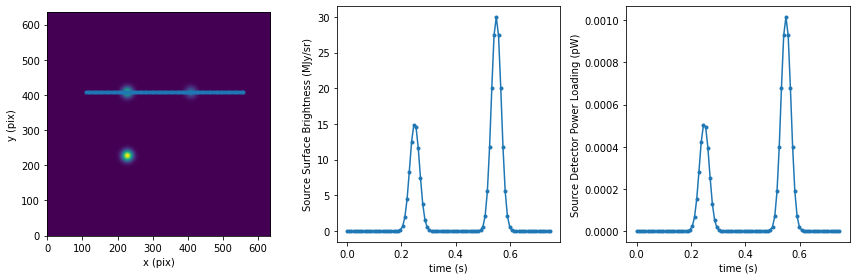

In [15]:
array_name = 'a1100'
hdu = m_img.data['hdu'][0]
wcsobj = WCS(hdu.header)
# this is to simulate a constant speed scan of length 1.5 arcmin
scan_speed = 2 << u.arcmin / u.s
f_smp = 122 << u.Hz
dra_deg = (scan_speed / f_smp).to_value(u.deg)
tel_ra = np.arange(180 - 0.5 / 60., 180 + 1 / 60, dra_deg) << u.deg
tel_dec = np.full(tel_ra.shape, 0.) << u.deg
tel_traj_icrs = SkyCoord(ra=tel_ra, dec=tel_dec, frame='icrs')
t_grid = np.arange(len(tel_ra)) / f_smp
tel_xx, tel_yy = wcsobj.world_to_pixel_values(tel_ra, tel_dec)
source_sb = hdu.data[tel_yy.astype(int), tel_xx.astype(int)] << u.MJy / u.sr
source_pwr = m_tpl.sky_sb_to_pwr(det_array_name=array_name, det_s=source_sb)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)
ax = axes[0]
ax.imshow(hdu.data, origin='lower')
ax.plot(tel_xx, tel_yy, marker='.')
ax.set_xlabel("x (pix)")
ax.set_ylabel("y (pix)")
ax = axes[1]
ax.plot(t_grid, source_sb.to_value(u.MJy/u.sr), marker='.')
ax.set_xlabel("time (s)")
ax.set_ylabel("Source Surface Brightness (MJy/sr)")
ax = axes[2]
ax.plot(t_grid, source_pwr.to_value(u.pW), marker='.')
ax.set_xlabel("time (s)")
ax.set_ylabel("Source Detector Power Loading (pW)")

This is only for the astronomical signal. The total detector powerloading includes both the astronomical signal and the fixure and atmosphere loading, which we can obtain from the TolTEC power loading model. To do so, we first need the telescope trajectory in altaz frame:

Text(0, 0.5, 'Total Detector Power Loading (pW)')

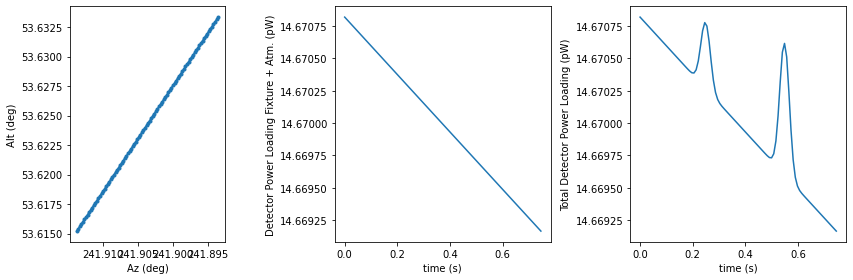

In [16]:
# t0 is the observation start time.
tel_traj_altaz = tel_traj_icrs.transform_to(lmt_observer.altaz(time=t_grid + t0))

# we can get the power for the am_q50 atm loading
# here we speed up the evaluation with a pre-built interp grid of step 0.3 arcmin
with m_tpl_am_q50.aplm_eval_interp_context(
    t0, t_grid,
    sky_bbox_altaz=None,
    alt_grid=np.arange(
        tel_traj_altaz.alt.degree.min(),
        tel_traj_altaz.alt.degree.max() + 0.3 / 60,
        0.3 / 60
        ) << u.deg):
    instru_pwr = m_tpl_am_q50.get_P(
        det_array_name=np.array([array_name]),  # just 1 detector
        det_az=None,
        det_alt=tel_traj_altaz.alt.reshape((1, len(tel_traj_altaz)))
        )[0]
det_pwr = instru_pwr + source_pwr
    
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)
ax = axes[0]
ax.set_aspect(1 / np.cos(tel_traj_altaz.alt.mean()))
ax.plot(tel_traj_altaz.az.degree, tel_traj_altaz.alt.degree, marker='.')
ax.set_xlabel('Az (deg)')
ax.set_ylabel('Alt (deg)')
ax.invert_xaxis()
ax = axes[1]
ax.plot(t_grid, instru_pwr)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detector Power Loading Fixture + Atm. (pW)")
ax = axes[2]
ax.plot(t_grid, det_pwr)
ax.set_xlabel("time (s)")
ax.set_ylabel("Total Detector Power Loading (pW)")

Now we have the detector power loading timestream, we can setup the KIDs resonance models.

We assume the KIDs TUNE is done when targeted at the mean altitude of the scan, without the presence of the astronomical signal. We can get the tune power by query the power loading model:

In [17]:
tune_alt = tel_traj_altaz.alt.mean()
tune_pwr = m_tpl_am_q50.get_P(
        det_array_name=np.array([array_name]),  # just 1 detector
        det_az=None,
        det_alt=np.array([[tune_alt.degree]]) << u.deg
        )[0][0]
print(f"Tune KIDs at alt={alt} P={tune_pwr:.4g}")

Tune KIDs at alt=50.0 deg P=14.67 pW


Since we only examine one detector, we'll create manually a `kidsproc.kidsmodel.simulator.KidsSimulator` object with the kids model params from first entry in the apt. We can "probe" the detector power loading to get the S21 response: 

KID fr=0.51677 GHz Qr=10000.0 resp.=5.794e-05 1 / pW


Text(0, 0.5, 'Detuning x')

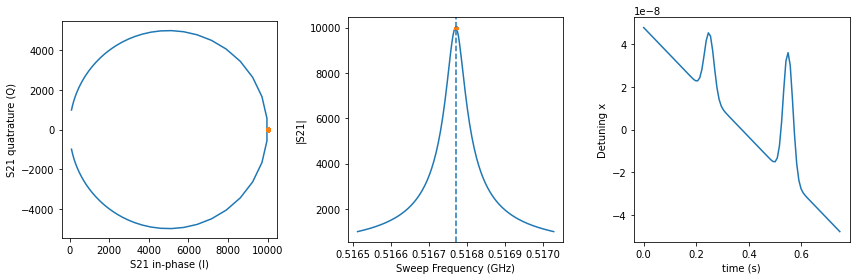

In [18]:
from kidsproc.kidsmodel.simulator import KidsSimulator
kpm = apt[0]
ks0 = KidsSimulator(fr=kpm['fr'], Qr=kpm['Qr'], responsivity=kpm['responsivity'], background=tune_pwr)
print(f"KID fr={ks0.fr} Qr={ks0._Qr} resp.={ks0._responsivity}")

# we can plot the resonance circle by doing a sweep
swp_x, swp_S21 = ks0.sweep_x(n_steps=176, n_fwhms=10)

# we can get S21 timestream by probing the det pwr stream
# the returned r and x are the "solved" values of the
# input signal, and S21 are the raw timestream.
ts_r, ts_x, ts_S21 = ks0.probe_p(det_pwr)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)
ax = axes[0]
ax.plot(swp_S21.real, swp_S21.imag)
ax.plot(ts_S21.real, ts_S21.imag, linestyle='none', marker='.')
ax.set_aspect('equal')
ax.set_xlabel("S21 in-phase (I)")
ax.set_ylabel("S21 quatrature (Q)")
ax = axes[1]
# x = f / fr - 1
# f = (x + 1 ) * fr
ax.plot(((swp_x + 1) * ks0.fr).to_value(u.GHz), np.abs(swp_S21))
ax.plot((ts_x + 1) * ks0.fr, np.abs(ts_S21), linestyle='none', marker='.')
ax.axvline(ks0.fr.to_value(u.GHz), linestyle='--')
ax.set_xlabel("Sweep Frequency (GHz)")
ax.set_ylabel("|S21|")
# plot the timestreams for x values
ax = axes[2]
ax.plot(t_grid, ts_x)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning x")

The final ingredient to the raw data stream that get written to the data files are the readout model, which is set to None in the above. The readout model simulates the gain and time delay of the readout circuit, which alters the "canonical" S21 response that we just plotted. Let's explore the real readout S21 values with the default readout model in the array prop table:

Model: ReadoutGainWithLinTrend
Inputs: ('S', 'f')
Outputs: ('S',)
Model set size: 1
Parameters:
      g0   g1    g   phi_g    f0     k0     k1    m0     m1   
                             GHz   1 / Hz 1 / Hz              
    ----- ---- ----- ----- ------- ------ ------ --- ---------
    200.0 60.0 200.0   0.0 0.51677    0.0    0.0 0.0 1000000.0


Text(0, 0.5, 'Readout Q')

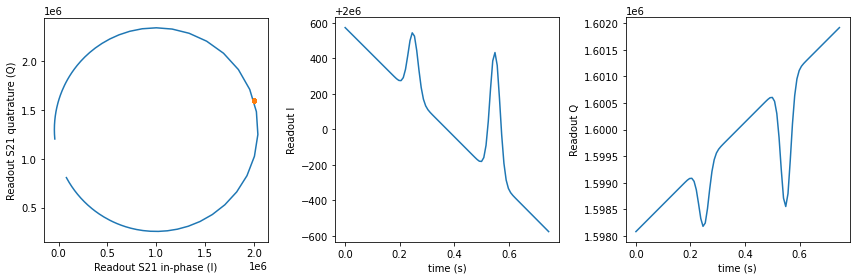

In [19]:
from kidsproc.kidsmodel import ReadoutGainWithLinTrend
# create the readout model for our detector
krm0 = ReadoutGainWithLinTrend(
    **{k: kpm[k] for k in ['g0', 'g1', 'g', 'phi_g', 'f0', 'k0', 'k1', 'm0', 'm1']}
    )
# the readout model created by the simulator
# is rather trivial. To better demonstrate the effects of the parameters
# we add the imaginary part to the complex gain
# which gives rotation of the circle in the I-Q plane and some shift.
krm0.g1 = 60
krm0.m1 = 1e6
print(krm0)
# apply the readout model
swp_S21_readout = krm0(swp_S21, (swp_x + 1) * ks0.fr)
ts_S21_readout = krm0(ts_S21, (ts_x + 1) * ks0.fr)

# plot the S21 circle

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)
ax = axes[0]
ax.plot(swp_S21_readout.real, swp_S21_readout.imag)
ax.plot(ts_S21_readout.real, ts_S21_readout.imag, linestyle='none', marker='.')
ax.set_aspect('equal')
ax.set_xlabel("Readout S21 in-phase (I)")
ax.set_ylabel("Readout S21 quatrature (Q)")
# plot the timestreams for S21
ax = axes[1]
ax.plot(t_grid, ts_S21_readout.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("Readout I")
ax = axes[2]
ax.plot(t_grid, ts_S21_readout.imag)
ax.set_xlabel("time (s)")
ax.set_ylabel("Readout Q")

Now let's try recover the on-sky astronomical signal from the timestream.

To do this, nominally, we'll need to solve the raw timestream with the KIDs model to get the timestream of the detuning parameter x, then we could use the responsivity of the detector to convert the x values to power loading unit, then back to surface brightness after combined with the TolTEC power loading model. For real observations, however, we take the more direct approach by doing the "beammap" observation. The beammap observation targets at a source with known flux, the conversion factor to go from detuning parameter x to surface brightness is compuated by comparing the measured flux of the beammap map and the actual source flux.

In the below, we use a trimmed down version of the latter, since we only have a short segment of timestream, by deriving the flux scale factor from comparing the timestream directly.

Power loading for 1 MJy/sr on sky: 3.3853523731768975e-05 pW
Detector power loading for 1 MJy/sr on sky: 14.670026204423172 pW
x value for 1 MJy/sr on sky: 1.9614731650241878e-09
x value for 1 MJy/sr on sky using responsivity: 1.9614731650241878e-09
responsivity: 5.794e-05 1 / pW
delta pwr for x=r: 0.8629616845012082 pW
delta sb for x=r: 25491.04463500699 MJy / sr
delta T_b for x=r: 11.170168525221998 K
flxscale factor: 5.0982e+08


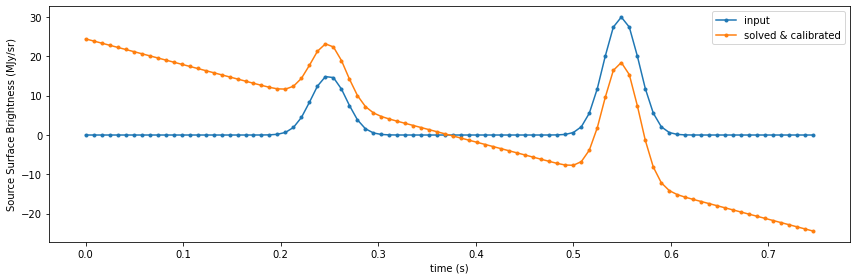

In [20]:
sky_sb_unity = 1 << u.MJy / u.sr
# now we use the kids model to infer the x value
sky_pwr_unity = m_tpl.sky_sb_to_pwr(det_array_name=array_name, det_s=sky_sb_unity)
print(f"Power loading for 1 MJy/sr on sky: {sky_pwr_unity}")
# the actual power loading on the detector is this plus the instr_pwr.
# here we set the instru_pwr to be the tune_pwr
# for simplicity
det_pwr_unity = sky_pwr_unity + tune_pwr
print(f"Detector power loading for 1 MJy/sr on sky: {det_pwr_unity}")

# we can probe the kids model to get the x values corresponding to this power
_, x_unity, _ = ks0.probe_p(det_pwr_unity)
print(f"x value for 1 MJy/sr on sky: {x_unity}")
# we can verify that this x value is consistent with the responsivity
# since we set the background to tune_pwr in the kids
print(f"x value for 1 MJy/sr on sky using responsivity: {(det_pwr_unity - tune_pwr) * ks0._responsivity}")
# the theta angle defined as atan2(x/r) is a measure of the noise degratation
x45 = ks0.fwhm_x / 2
delta_pwr_x45 = x45 / ks0._responsivity
delta_sb_x45 = (x45 / x_unity).value << u.MJy/u.sr
print(f"responsivity: {ks0._responsivity}")
print(f"delta pwr for x=r: {delta_pwr_x45}")
print(f"delta sb for x=r: {delta_sb_x45}")
f_band = toltec_info[array_name]['wl_center'].to(u.GHz, equivalencies=u.spectral())
print(f"delta T_b for x=r: {delta_sb_x45.to(u.K, equivalencies=u.brightness_temperature(frequency=f_band))}")

print(f"flxscale factor: {1 / x_unity:.5g}")
# now we could use the x_unity as the scaling factor to
# convert the timestream back to surface brightness unit
ts_sb = (ts_x / x_unity).value << u.MJy / u.sr

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fig.set_tight_layout(True)
ax.plot(t_grid, source_sb.to_value(u.MJy/u.sr), marker='.', label='input')
ax.plot(t_grid, ts_sb.to_value(u.MJy/u.sr), marker='.', label='solved & calibrated')
ax.set_xlabel("time (s)")
ax.set_ylabel("Source Surface Brightness (MJy/sr)")
ax.legend()

From the plot above we could see the recovered timestream is not the same as the input one. This is due to the power loading gradient in the atmosphere model. For real observations, the atmosphere power loading signature is even more complex due to the fluctuations and these signatures have to be removed in the data reduction in order to reveal the actual astronominal signal, which is implemented in the data reduction engine Citlali.

The static atomsphere model built-in to tolteca could only provide the gradient. To simulate the fluctuations of the atmosphere, set the ``atm_model_name`` to ``toast``, which makes use of the TOAST package.

### Examine the KIDs data in raw timestream netCDF file

The output data files produced by the simulator are netCDF format and have the same strcture as those from the real observations. In this section we give an example of how to examing the content of these files.

The ``tolteca.datamodels`` package defines the classes that handles the reading of data files. For TolTEC, this is done by the `tolteca.datamodels.toltec.BasicObsData` class. Each TolTEC observation will produce 13 KIDs data files, one for each of the detector network.

TolTEC data file to open: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec0_000001_000_0000_2022_03_26_03_23_19_timestream.nc
NcFileIO(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpj5ri0i0b/simu_three_sources/toltec0_000001_000_0000_2022_03_26_03_23_19_timestream.nc)
Model: KidsSweepGainWithLinTrend
Inputs: ('f',)
Outputs: ('S',)
Model set size: 684
Parameters:
            fr            Qr     g0   g1   g   phi_g         f0          k0  k1  m0  m1
            Hz                                               Hz          s   s         
    ------------------ ------- ----- --- ----- ----- ------------------ --- --- --- ---
    516769999.99999994 10000.0 200.0 0.0 200.0   0.0 516769999.99999994 0.0 0.0 0.0 0.0
           736856000.0 10000.0 200.0 0.0 200.0   0.0        736856000.0 0.0 0.0 0.0 0.0
           608774000.0 10000.0 200.0 0.0 200.0   0.0        608774000.0 0.0 0.0 0.0 0.0
           864924000.0 10000.0 200.0 0.0 200.0  

Text(0, 0.5, 'Calibrated timestream (pW)')

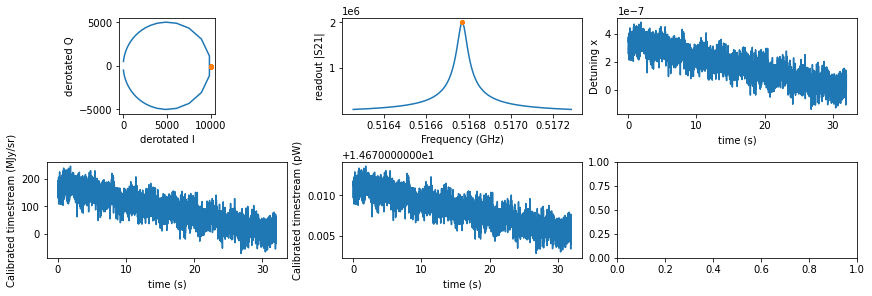

In [21]:
from tolteca.datamodels.toltec import BasicObsData
from tolteca.datamodels.io.toltec.table import KidsModelParams
from astropy.table import QTable

toltec0_file = next(iter(output_dir.glob("toltec0*.nc")))
print(f"TolTEC data file to open: {toltec0_file}")

bod = BasicObsData(toltec0_file)

fo = bod.open()
# fo is the NcFileIO object that handles the IO to the nc file
print(fo)
mpt = fo.get_model_params_table()
# print(mpt)

# now we can create the KidsModelParams object
kmp = KidsModelParams(table=mpt)
# print(kmp)

# and further we can get the kidsproc.kidsmodel.KidsModel
# note that this model is a astropy.models.ModelSet of size matches the
# number of detectors in the network
print(kmp.model)

# To get the model for a single detector, use get_model
km0 = kmp.get_model(i=0)
print(km0)

# we can evalaute this model with a grid of probing frequency
# centered at the resonance frequency
fwhm = km0.fr / km0.Qr
f_grid = np.linspace(
    km0.fr.quantity.to_value(u.Hz) - 10 * fwhm.to_value(u.Hz),
    km0.fr.quantity.to_value(u.Hz) + 10 * fwhm.to_value(u.Hz),
    176
    ) << u.Hz
swp_S21 = km0(f_grid)
# the derotated S21 without readout gain model
swp_S21_derot = km0.derotate(swp_S21, f_grid)

# we can get the raw I and Q timestream from reading the timestream file
ts_all = fo.read()
print(f"Timestream for all detectors: {ts_all}")

# and get the timestream data for the first detector
ts0 = ts_all[0]
print(f"Timestream for detector i=0: {ts0}")
# the timestream have I and Q stored separately
ts0_S21 = ts0.I.value + 1.j * ts0.Q.value

# we can derotate the timestream with the sweep model
# the probe frequency is set to the resonance frequency
ts0_S21_derot = km0.derotate(ts0_S21, np.full(ts0_S21.shape, km0.fr.quantity.to_value(u.Hz)) << u.Hz)
# the deroted S21 can be converted back to r and x using the resonance circle model
from kidsproc.kidsmodel import ResonanceCircleComplexInv
# the x values is the imaginary part
ts0_rx = ResonanceCircleComplexInv()(ts0_S21_derot)
ts0_x = ts0_rx.imag

# the conversion factor to go from x to sb is written in the simulator output apt
# we use the value to get the surface brightness
apt_file = next(iter(output_dir.glob("apt_*.ecsv")))
print(f"APT to open: {apt_file}")
apt = QTable.read(apt_file, format='ascii.ecsv')
# print(apt[['fr', 'Qr', 'x_t', 'y_t']])
flxscale = apt[0]['flxscale'] << u.MJy/u.sr
print(f"flux convesion factor: {flxscale:.5g}")

# apply the flux conversion to get calibarted timestream in MJy/sr
ts0_sb = (ts0_x * flxscale)
# use the power loading model we can get the timestream in power unit
# because the kidsmodel is tuned at background, we add the zero point back
ts0_pwr = m_tpl.sky_sb_to_pwr(det_array_name=array_name, det_s=ts0_sb) + apt[0]['background']

# we need the t_grid for the timestream, which we can get from
# the f_smp
f_smp = simrt.config.obs_params.f_smp_probing
t_grid = np.arange(len(ts0_sb)) / f_smp

fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(12, 4))
axes = axes.ravel()
ax = axes[0]
ax.plot(swp_S21_derot.real, swp_S21_derot.imag)
ax.plot(ts0_S21_derot.real, ts0_S21_derot.imag, marker='.', linestyle='none')
ax.set_xlabel("derotated I")
ax.set_ylabel("derotated Q")
ax.set_aspect('equal')
ax = axes[1]
ax.plot(f_grid.to_value(u.GHz), np.abs(swp_S21))
ax.plot(((ts0_x + 1) * km0.fr.quantity).to_value(u.GHz), np.abs(ts0_S21), marker='.', linestyle='none')
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("readout |S21|")
# plot the timestreams
ax = axes[2]
ax.plot(t_grid, ts0_x)
ax.set_xlabel("time (s)")
ax.set_ylabel("Detuning x")
ax = axes[3]
ax.plot(t_grid, ts0_sb.to_value(u.MJy/u.sr))
ax.set_xlabel("time (s)")
ax.set_ylabel("Calibrated timestream (MJy/sr)")
ax = axes[4]
ax.plot(t_grid, ts0_pwr.to_value(u.pW))
ax.set_xlabel("time (s)")
ax.set_ylabel("Calibrated timestream (pW)")

We could see from the plot that the timestreams are quite noisy. We could verify the property of the calibrated timestream by "removing" the atmosphere using the power loading model.

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Header.File.Name_slen(128), Header.Source.SourceName_slen(128), Header.Dcs.ObsPgm_slen(128), Header.Source.Ra_xlen(2), time(3840)
    variables(dimensions): |S1 Header.File.Name(Header.File.Name_slen), |S1 Header.Source.SourceName(Header.Source.SourceName_slen), |S1 Header.Dcs.ObsPgm(Header.Dcs.ObsPgm_slen), float64 Header.Source.Ra(Header.Source.Ra_xlen), float64 Header.Source.Dec(Header.Source.Ra_xlen), float64 Data.TelescopeBackend.TelTime(time), float64 Data.TelescopeBackend.TelRaAct(time), float64 Data.TelescopeBackend.TelDecAct(time), float64 Data.TelescopeBackend.TelElAct(time), float64 Data.TelescopeBackend.TelAzAct(time), float64 Data.TelescopeBackend.ActParAng(time), float64 Data.TelescopeBackend.TelElSky(time), float64 Data.TelescopeBackend.TelAzSky(time), float64 Data.TelescopeBackend.ParAng(time), float64 Data.TelescopeBackend.Hold(time), float64 Data.TelescopeBacke

Text(0, 0.5, 'Input Detector Power Loading from Sky (pW)')

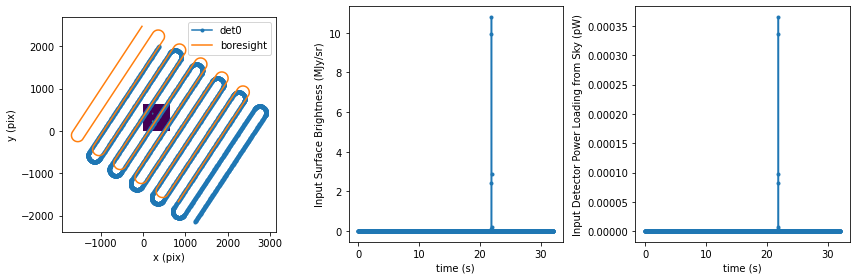

In [22]:
# get the trajectory of the first detector using
# sky projection model of the simulator
# we open the tel.nc file to retrieve the boresight coords
from tolteca.simu.toltec.models import ToltecSkyProjModel

tel_file = next(iter(output_dir.glob("tel_*.nc")))

# the current version of tolteca does not provide
# high level class to manage tel.nc.
from netCDF4 import Dataset
tel_nc = Dataset(tel_file)
print(tel_nc)
tel_traj_ra = tel_nc.variables["Data.TelescopeBackend.TelRaAct"][:] << u.rad
tel_traj_dec = tel_nc.variables["Data.TelescopeBackend.TelDecAct"][:] << u.rad
tel_traj_az = tel_nc.variables["Data.TelescopeBackend.TelAzAct"][:] << u.rad
tel_traj_alt = tel_nc.variables["Data.TelescopeBackend.TelElAct"][:] << u.rad
tel_time = Time(tel_nc.variables['Data.TelescopeBackend.TelTime'][:], format='unix')
# print(tel_time.iso)
tel_traj_icrs = SkyCoord(ra=tel_traj_ra, dec=tel_traj_dec, frame='icrs')
tel_traj_altaz = SkyCoord(az=tel_traj_az, alt=tel_traj_alt, frame=lmt_observer.altaz(time=tel_time))

m_sky_proj = ToltecSkyProjModel(
    origin_coords_icrs=tel_traj_icrs,
    origin_coords_altaz=tel_traj_altaz)

# here because we need all the coords for plotting, we
# return the eval context and set evaluate_frame to icrs
_, det0_traj_ctx = m_sky_proj(
    apt[0]['x_t'], apt[0]['y_t'], apt[0]['pa_t'],
    evaluate_frame='icrs',
    return_eval_context=True)
det0_traj_icrs = det0_traj_ctx['coords_icrs']
det0_traj_altaz = det0_traj_ctx['coords_altaz']


# extract the input timestream from the image model
# for plotting
array_name = 'a1100'
hdu = m_img.data['hdu'][0]
wcsobj = WCS(hdu.header)
tel_xx, tel_yy = wcsobj.world_to_pixel_values(tel_traj_icrs.ra.degree, tel_traj_icrs.dec.degree)
det0_xx, det0_yy = wcsobj.world_to_pixel_values(det0_traj_icrs.ra.degree, det0_traj_icrs.dec.degree)
# here because the xx and yy could be out of bound, need to handle that with a mask
det0_yy = det0_yy.astype(int)
det0_xx = det0_xx.astype(int)
gm = (det0_yy < hdu.data.shape[0]) & (det0_yy >= 0) & (det0_xx < hdu.data.shape[1]) & (det0_xx >= 0)
det0_sky_sb_input = np.zeros(det0_yy.shape, dtype='d') << u.MJy / u.sr
det0_sky_sb_input[gm] = hdu.data[det0_yy[gm], det0_xx[gm]] << u.MJy / u.sr
det0_sky_pwr_input = m_tpl.sky_sb_to_pwr(det_array_name=array_name, det_s=det0_sky_sb_input)

# get fixure + atm power loading input:
# here we speed up the evaluation with a pre-built interp grid of step 1 arcmin
# need to also take into account the array FOV of 4armin in the padding
with m_tpl_am_q50.aplm_eval_interp_context(
    t0, t_grid,
    sky_bbox_altaz=None,
    alt_grid=np.arange(
        tel_traj_altaz.alt.degree.min() - 4 / 60,
        tel_traj_altaz.alt.degree.max() + 1 / 60 + 4 / 60,
        1 / 60
        ) << u.deg):
    instru_pwr = m_tpl_am_q50.get_P(
        det_array_name=np.array([array_name]),  # just 1 detector
        det_az=None,
        det_alt=det0_traj_altaz.alt.reshape((1, len(det0_traj_altaz)))
        )[0]
det0_pwr_input = instru_pwr + det0_sky_pwr_input


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.set_tight_layout(True)
ax = axes[0]
ax.imshow(hdu.data, origin='lower')
ax.plot(det0_xx, det0_yy, marker='.', label='det0')
ax.plot(tel_xx, tel_yy, label='boresight')
ax.set_xlabel("x (pix)")
ax.set_ylabel("y (pix)")
ax.legend()
ax = axes[1]
ax.plot(t_grid, det0_sky_sb_input.to_value(u.MJy/u.sr), marker='.')
ax.set_xlabel("time (s)")
ax.set_ylabel("Input Surface Brightness (MJy/sr)")
ax = axes[2]
ax.plot(t_grid, det0_sky_pwr_input.to_value(u.pW), marker='.')
ax.set_xlabel("time (s)")
ax.set_ylabel("Input Detector Power Loading from Sky (pW)")

[14.68116901 14.68179691 14.679666   ... 14.67484796 14.67508873
 14.67715726] pW


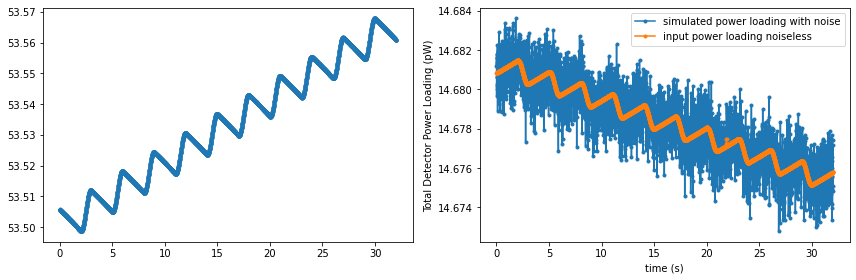

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.set_tight_layout(True)
ax = axes[0]
# altitude vs t
ax.plot(t_grid, det0_traj_altaz.alt.degree, marker='.')
# noiseless input total power loading
ax = axes[1]
print(ts0_pwr)
ax.plot(t_grid, ts0_pwr.to_value(u.pW), marker='.', label='simulated power loading with noise')
ax.plot(t_grid, det0_pwr_input.to_value(u.pW), marker='.', label='input power loading noiseless')
ax.set_xlabel("time (s)")
ax.set_ylabel("Total Detector Power Loading (pW)")
ax.legend()